Author: Pavel Khokhlov (pkhokhlo@alumni.cmu.edu)

# Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pickle
import random
import copy
import os
import gc

In [2]:
import pandas as pd
# good to never do chained assignment
pd.set_option('mode.chained_assignment', 'raise')
#pd.set_option('mode.chained_assignment', 'warn') # default
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('max_columns', 999)
pd.set_option('max_rows', 40)

In [3]:
plt.rcParams['figure.figsize'] = np.array([12, 8])
sb.set(rc={"xtick.bottom" : True,
           "ytick.left" : True,
           'axes.titlesize': 21,
           'axes.labelsize': 20,
           'xtick.labelsize': 18,
           'ytick.labelsize': 18,
           'legend.fontsize': 16,
          }, style='whitegrid')

In [4]:
import torch
from torch import distributions
from torch import nn
import torch.utils.data as utils

import sys
sys.path.append("pytorch-generative")
from pytorch_generative import nn as pg_nn
from pytorch_generative.models import base

In [5]:
random.seed(10)

In [6]:
BATCH_SIZE = 32

In [7]:
MIN_TEST_DATE = '20060101'
MIN_YEAR = 2000
MAX_YEAR = 2008

In [8]:
MODEL_STATE = 'model_state_406_new'

#DAV_DIRECTORY = 'dav_profiles'
SIZE_DIRECTORY = 'size_400km_mask'
RAD_DIRECTORY = 'size_and_radial_prof'
TC_DIRECTORY = 'size_and_radial_prof'

LOG_DIRECTORY = 'run_multiorb_size_mask/'

# size calculation function

In [9]:
def distance_from_coord(lat1, lat2, lon1, lon2):
    """
    Return distance in KM given a pair of lat-lon coordinates.
    :param lat1: Starting latitude
    :param lat2: Ending latitude
    :param lon1: Starting Longitude
    :param lon2: Ending longitude
    :return: Arc length of great circle
    """
    # https://www.movable-type.co.uk/scripts/latlong.html
    R = 6371
    latDel = lat1 - lat2
    lonDel = lon1 - lon2
    a = (
            np.sin(latDel / 2 * np.pi / 180) ** 2 +
            np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) *
            np.sin(lonDel / 2 * np.pi / 180) ** 2
    )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def coord_from_distance(lat, lon, distance):
    """
    Find the bounding box for the stamp based on center coord and distance
    :param lat: Latitude of stamp center
    :param lon: Longitude of stamp center
    :param distance: Stamp radius
    :return: Dictionary of bounding latitudes and longitudes for stamp
    """
    # https://www.movable-type.co.uk/scripts/latlong.html
    R = 6371
    latEnd = [float()] * 360
    lonEnd = [float()] * 360
    bearings = range(0, 360)
    distance = float(distance)
    ii = 0
    for bearing in bearings:
        latEnd[ii] = np.arcsin(np.sin(lat * np.pi / 180) * np.cos(distance / R) +
                               np.cos(lat * np.pi / 180) * np.sin(distance / R) *
                               np.cos(bearing * np.pi / 180)
                               ) * 180 / np.pi
        lonEnd[ii] = lon + np.arctan2(
            np.sin(bearing * np.pi / 180) * np.sin(distance / R) * np.cos(lat * np.pi / 180),
            np.cos(distance / R) - np.sin(lat * np.pi / 180) * np.sin(latEnd[ii] * np.pi / 180)
        ) * 180 / np.pi
        ii += 1
    return ({
        'latHi': np.max(latEnd),
        'latLo': np.min(latEnd),
        'lonHi': np.max(lonEnd),
        'lonLo': np.min(lonEnd)
    })


stamp_area_cached = {}
def stamp_area(lat, distance=400, resolution=0.04):
    """
    Find the number of pixels in a stamp at a given latitude
    :param lat: Latitude of stamp center
    :param distance: Stamp radius
    :return: integer number of pixels in image
    """
    global stamp_area_cached
    if stamp_area_cached.get(lat):
        return stamp_area_cached.get(lat)
    bbox = coord_from_distance(lat, 0, distance)
    # Build the grid
    latpix = np.int(np.ceil((bbox['latHi'] - bbox['latLo']) / resolution))
    if latpix % 2 == 0:
        latpix += 1
    lonpix = np.int(np.ceil((bbox['lonHi'] - bbox['lonLo']) / resolution))
    if lonpix % 2 == 0:
        lonpix += 1
    lats = [resolution*(ii - np.floor(latpix/2)) for ii in range(latpix)]
    lons = [resolution*(ii - np.floor(lonpix/2)) for ii in range(lonpix)]
    grid = np.array(np.meshgrid(lats, lons)).reshape(2, latpix*lonpix).T
    # Compute radii over grid
    rads = distance_from_coord(lat * np.ones((grid.shape[0])),
                               lat * np.ones((grid.shape[0])) + grid[:, 0],
                               np.zeros((grid.shape[0])),
                               grid[:, 1])
    val = np.sum(rads < distance)
    stamp_area_cached[lat] = val
    return val

# Data loading

In [10]:
def get_orb_files(file_dir, location_prefix, orb_suffix, min_year=2000, max_year=2005):
    years = [str(i) for i in range(min_year, max_year + 1)]
    files = os.listdir(file_dir)
    rad_files = []
    for f in files:
        is_orb = orb_suffix in f
        year_valid = False
        location_valid = f.startswith(location_prefix)
        for year in years:
            year_valid = year_valid or (year in f)
        if is_orb and year_valid and location_valid:
            rad_files.append(f)
    return rad_files

In [11]:
#dav_files = get_orb_files(DAV_DIRECTORY, 'AL', '_DAV.csv', min_year=MIN_YEAR, max_year=MAX_YEAR)
#dacv_files = get_orb_files(DAV_DIRECTORY, 'AL', '_DACV.csv', min_year=MIN_YEAR, max_year=MAX_YEAR)
#darv_files = get_orb_files(DAV_DIRECTORY, 'AL', '_DARV.csv', min_year=MIN_YEAR, max_year=MAX_YEAR)
rad_files = get_orb_files(RAD_DIRECTORY, 'AL', '_rad.csv', min_year=MIN_YEAR, max_year=MAX_YEAR)
size_files = get_orb_files(SIZE_DIRECTORY, 'AL', '-size.csv', min_year=MIN_YEAR, max_year=MAX_YEAR)
tc_files = get_orb_files(TC_DIRECTORY, 'AL', '_TCdata.csv', min_year=MIN_YEAR, max_year=MAX_YEAR)

## size dataframe

In [12]:
dfs = []
for f in size_files:
    path = f'{SIZE_DIRECTORY}/{f}'
    storm_id = f.split('-')[0]
    df = pd.read_csv(path, header=0, skiprows=[0, 2])
    del df['Unnamed: 1']
    del df['time']
    df = df.transpose()
    df.reset_index(inplace=True)
    df.rename(columns=dict([(i, str(int(i) - 100)) for i in range(100)]), inplace=True)
    df.rename(columns={'index': 'timestamp'}, inplace=True)
    df['ID'] = storm_id
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.round('min')
    dfs.append(df)
df_size = pd.concat(dfs)

In [13]:
size_cols = [str(i) for i in range(-1, -100 - 1, -1)]

## RAD dataframe

In [14]:
dfs = []
for f in rad_files:
    path = f'{RAD_DIRECTORY}/{f}'
    storm_id = f.split('_')[0]
    df = pd.read_csv(path, header=0, skiprows=[0, 2])
    df.rename(columns={'radius': 'timestamp'}, inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.round('min')
    df['ID'] = storm_id
    df.rename(columns=dict([(str(float(i)), str(i)) for i in range(5, 600 + 5, 5)]), inplace=True)
    df.sort_values('timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)
    dfs.append(df)
df_rad = pd.concat(dfs)

In [15]:
rad_cols = [str(i) for i in range(5, 600 + 5, 5)]

## TCdata dataframe

In [16]:
dfs = []
for f in tc_files:
    path = f'{TC_DIRECTORY}/{f}'
    storm_id = f.split('_')[0]
    df = pd.read_csv(path, header=0)
    df.rename(columns={'TIMESTAMP': 'timestamp'}, inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.round('min')
    df = df.resample('0.5H', on='timestamp').mean().reset_index().interpolate()
    df['LAT'] = df['LAT'].round(1)
    df['ID'] = storm_id
    dfs.append(df[['ID', 'timestamp', 'LAT', 'WIND']])
df_tc = pd.concat(dfs)

## dataframe merge

merge on timestamp and ID

In [17]:
df_size_rad = df_size.merge(df_rad, how='inner', on=['timestamp', 'ID'], suffixes=('_size', '_rad'))

In [18]:
df_size_rad_tc = df_size_rad.merge(df_tc, how='inner', on=['timestamp', 'ID'], suffixes=('', '_tc'))

In [19]:
storm_ids = list(df_size_rad_tc['ID'].unique())

## size normalization

In [20]:
area = df_size_rad_tc['LAT'].apply(stamp_area)

In [21]:
df_size_rad_tc['area'] = area

In [22]:
# normalize raw number pixels by image size
for size_col in size_cols:
    df_size_rad_tc[size_col] = df_size_rad_tc[size_col] / df_size_rad_tc['area']

# PCA size

In [23]:
from sklearn.decomposition import PCA

In [24]:
pca_size = PCA(n_components=3)
X_size_pca = df_size_rad_tc.loc[df_size_rad_tc['timestamp'] < MIN_TEST_DATE, size_cols].sample(frac=0.1)
size_cols_means = X_size_pca.mean(0)
X_size_pca -= size_cols_means

In [25]:
pca_size.fit(X_size_pca)

PCA(n_components=3)

In [26]:
size_pca_trans = pca_size.transform(df_size_rad_tc.loc[:, size_cols] - size_cols_means)

In [27]:
df_size_rad_tc['size_pca1'] = size_pca_trans[:, 0]
df_size_rad_tc['size_pca2'] = size_pca_trans[:, 1]
df_size_rad_tc['size_pca3'] = size_pca_trans[:, 2]

# PCA rad

In [28]:
pca_rad = PCA(n_components=2)
X_rad_pca = df_size_rad_tc.loc[df_size_rad_tc['timestamp'] < MIN_TEST_DATE, rad_cols].dropna().sample(frac=0.1)
rad_cols_means = X_rad_pca.mean(0)
X_rad_pca -= rad_cols_means

pca_rad.fit(X_rad_pca)

no_null_rows = np.array(df_size_rad_tc.loc[:, rad_cols].isna().sum(1) == 0)

rad_pca_trans = pca_rad.transform(df_size_rad_tc.loc[no_null_rows, rad_cols] - rad_cols_means)

df_size_rad_tc['rad_pca1'] = np.nan
df_size_rad_tc['rad_pca2'] = np.nan

df_size_rad_tc.loc[no_null_rows, 'rad_pca1'] = rad_pca_trans[:, 0]
df_size_rad_tc.loc[no_null_rows, 'rad_pca2'] = rad_pca_trans[:, 1]

# test tensor

In [29]:
slices_test = []
total = 0
size_nan = 0
for storm_id in storm_ids:
    if (df_size_rad_tc.loc[df_size_rad_tc['ID'] == storm_id, 'timestamp'] < MIN_TEST_DATE).sum() == 0:
        storm_df = df_size_rad_tc.loc[df_size_rad_tc['ID'] == storm_id, :].sort_values('timestamp')

        size_mtx = storm_df[size_cols].values
        rad_mtx = storm_df[rad_cols].values

        wind_vec = storm_df['WIND'].values
        wind_diff_vec = storm_df['WIND'].diff().values
    
        rad_pca1_mtx = storm_df['rad_pca1'].shift(1).values
        rad_pca2_mtx = storm_df['rad_pca2'].shift(1).values

        size_pca1_mtx = storm_df['size_pca1'].shift(1).values
        size_pca2_mtx = storm_df['size_pca2'].shift(1).values
        size_pca3_mtx = storm_df['size_pca3'].shift(1).values

        assert(rad_mtx.shape[0] == size_mtx.shape[0])
        for jj in range(size_mtx.shape[0] - 60):
            total += 1
            s_size = size_mtx[jj:(jj + 60)]
            s_rad = rad_mtx[jj:(jj + 60)]

            s_wind = wind_vec[jj:(jj + 60)]
            s_wind_diff = wind_diff_vec[jj:(jj + 60)]

            s_rad_pca1 = rad_pca1_mtx[jj:(jj + 60)]
            s_rad_pca2 = rad_pca2_mtx[jj:(jj + 60)]

            s_size_pca1 = size_pca1_mtx[jj:(jj + 60)]
            s_size_pca2 = size_pca2_mtx[jj:(jj + 60)]
            s_size_pca3 = size_pca3_mtx[jj:(jj + 60)]

            if(np.isnan(s_size).any()
               or np.isnan(s_rad).any()
               or np.isnan(s_wind).any()
               or np.isnan(s_wind_diff).any()
               or np.isnan(s_rad_pca1).any()
               or np.isnan(s_rad_pca2).any()
               or np.isnan(s_size_pca1).any()
               or np.isnan(s_size_pca2).any()
               or np.isnan(s_size_pca3).any()
              ):
                continue
            slices_test.append([
                    s_size,
                    s_rad,
                    s_wind,
                    s_wind_diff,
                    s_rad_pca1,
                    s_rad_pca2,
                    s_size_pca1,
                    s_size_pca2,
                    s_size_pca3,
            ])

In [30]:
## Stack all matrices together first, before splitting into training and test

size_np = np.stack(([el[0] for el in slices_test]), axis=0)
rad_np = np.stack(([el[1] for el in slices_test]), axis=0)

# We create a multi-channel matrix of the same size as size_np and rad_np
# in which we store the extra information we would like the last CNN to use for prediction

int_size_np = np.repeat(np.stack(([el[2] for el in slices_test]), axis=0)[:, :, np.newaxis], size_np.shape[2], axis=2)
int_diff_size_np = np.repeat(np.stack(([el[3] for el in slices_test]), axis=0)[:, :, np.newaxis], size_np.shape[2], axis=2)
rad_pca1_np = np.repeat(np.stack(([el[4] for el in slices_test]), axis=0)[:, :, np.newaxis], size_np.shape[2], axis=2)
rad_pca2_np = np.repeat(np.stack(([el[5] for el in slices_test]), axis=0)[:, :, np.newaxis], size_np.shape[2], axis=2)
extra_feats_size_np = np.stack((
    int_size_np, int_diff_size_np, rad_pca1_np, rad_pca2_np), axis=1)

int_rad_np = np.repeat(np.stack(([el[2] for el in slices_test]), axis=0)[:, :, np.newaxis], rad_np.shape[2], axis=2)
int_diff_rad_np = np.repeat(np.stack(([el[3] for el in slices_test]), axis=0)[:, :, np.newaxis], rad_np.shape[2], axis=2)
size_pca1_np = np.repeat(np.stack(([el[6] for el in slices_test]), axis=0)[:, :, np.newaxis], rad_np.shape[2], axis=2)
size_pca2_np = np.repeat(np.stack(([el[7] for el in slices_test]), axis=0)[:, :, np.newaxis], rad_np.shape[2], axis=2)
size_pca3_np = np.repeat(np.stack(([el[8] for el in slices_test]), axis=0)[:, :, np.newaxis], rad_np.shape[2], axis=2)
extra_feats_rad_np = np.stack((
    int_rad_np, int_diff_rad_np, size_pca1_np, size_pca2_np, size_pca3_np), axis=1)

print(size_np.shape, rad_np.shape)
print(int_size_np.shape, int_diff_size_np.shape, rad_pca1_np.shape, rad_pca2_np.shape)
print(extra_feats_size_np.shape)

print(int_rad_np.shape, int_diff_rad_np.shape, size_pca1_np.shape, size_pca2_np.shape, size_pca3_np.shape)
print(extra_feats_rad_np.shape)

# This dictionary will be important later to pass the arguments to the NN Architecture
dict_sizes_orb = {'channels_size':extra_feats_size_np.shape[1], 
                  'channels_rad':extra_feats_rad_np.shape[1]}
print(dict_sizes_orb)

(6193, 60, 100) (6193, 60, 120)
(6193, 60, 100) (6193, 60, 100) (6193, 60, 100) (6193, 60, 100)
(6193, 4, 60, 100)
(6193, 60, 120) (6193, 60, 120) (6193, 60, 120) (6193, 60, 120) (6193, 60, 120)
(6193, 5, 60, 120)
{'channels_size': 4, 'channels_rad': 5}


# tensor dimensions

In [31]:
print(size_np.shape, rad_np.shape, extra_feats_size_np.shape, extra_feats_rad_np.shape)

(6193, 60, 100) (6193, 60, 120) (6193, 4, 60, 100) (6193, 5, 60, 120)


In [32]:
del size_pca1_np, size_pca2_np, size_pca3_np, int_size_np, int_diff_size_np, rad_pca1_np, rad_pca2_np

In [33]:
gc.collect()

0

## Multi-head Model

In [34]:
import torch
from torch import distributions
from torch import nn

from pytorch_generative import nn as pg_nn
from pytorch_generative.models import base
from pytorch_generative.models.autoregressive.pixel_cnn import CausalResidualBlock


class PixelCNNMultiHead(base.AutoregressiveModel):
    """The PixelCNN model, initialized with multiple heads so to accommodate different
    orbs and other variabels."""

    def __init__(
        self,
        channels_size, channels_rad,
        in_channels=1,
        out_channels=1,
        n_residual=15,
        residual_channels=128,
        head_channels=32,
        sample_fn=None,
    ):
        """Initializes a new PixelCNN Multi Head instance.

        Args:
            in_channels: The number of input channels.
            out_channels: The number of output channels.
            n_residual: The number of residual blocks.
            residual_channels: The number of channels to use in the residual layers.
            head_channels: The number of channels to use in the two 1x1 convolutional
                layers at the head of the network.
            sample_fn: See the base class.
        """
        super().__init__(sample_fn)
        self._input_h1 = pg_nn.CausalConv2d(
            mask_center=True,
            in_channels=in_channels,
            out_channels=2 * residual_channels,
            kernel_size=7,
            padding=3,
        )
        self._causal_layers_h1 = nn.ModuleList(
            [
                CausalResidualBlock(n_channels=2 * residual_channels)
                for _ in range(n_residual)
            ]
        )
        self._head_h1 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(
                in_channels=2 * residual_channels,
                out_channels=head_channels,
                kernel_size=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=head_channels, out_channels=out_channels, kernel_size=1
            )
        )
        
        
        self._input_h2 = pg_nn.CausalConv2d(
            mask_center=True,
            in_channels=in_channels,
            out_channels=2 * residual_channels,
            kernel_size=7,
            padding=3,
        )
        self._causal_layers_h2 = nn.ModuleList(
            [
                CausalResidualBlock(n_channels=2 * residual_channels)
                for _ in range(n_residual)
            ]
        )
        self._head_h2 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(
                in_channels=2 * residual_channels,
                out_channels=head_channels,
                kernel_size=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=head_channels, out_channels=out_channels, kernel_size=1
            )
        )
        
        self.cnn_size_final = nn.Conv2d(in_channels=out_channels + channels_size,
                                        out_channels=out_channels, kernel_size=1)
        self.cnn_rad_final = nn.Conv2d(in_channels=out_channels + channels_rad,
                                        out_channels=out_channels, kernel_size=1)

    def forward(self, size_orb, rad_orb, feats_size, feats_rad):
        # First propagate the first orb
        size_orb = self._input_h1(size_orb)
        for layer in self._causal_layers_h1:
            size_orb = size_orb + layer(size_orb)
        size_orb = self._head_h1(size_orb)
        
        # Then propagate the second orb
        rad_orb = self._input_h2(rad_orb)
        for layer in self._causal_layers_h2:
            rad_orb = rad_orb + layer(rad_orb)
        rad_orb = self._head_h2(rad_orb)
        
        # Attach all channels to both orbs
        size_orb_full = torch.cat((size_orb, feats_size), 1)
        rad_orb_full = torch.cat((rad_orb, feats_rad), 1)
        
        # Run the final convolutions
        size_preds = self.cnn_size_final(size_orb_full)
        rad_preds = self.cnn_rad_final(rad_orb_full)
        
        return size_preds, rad_preds

# model load

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
cpu_dev = torch.device('cpu')
model = PixelCNNMultiHead(
    in_channels=1,
    out_channels=2,
    n_residual=15,
    residual_channels=16,
    head_channels=32,
    **dict_sizes_orb
)
model.load_state_dict(torch.load(MODEL_STATE))
model = model.to(device)

In [36]:
next(model.parameters()).is_cuda

True

# forward pass conditioned on true

In [37]:
i = 6100
pred = model.forward(
    torch.Tensor([[size_np[i]]]).to(device),
    torch.Tensor([[rad_np[i]]]).to(device),
    torch.Tensor([extra_feats_size_np[i]]).to(device),
    torch.Tensor([extra_feats_rad_np[i]]).to(device),
)

## size

### mean

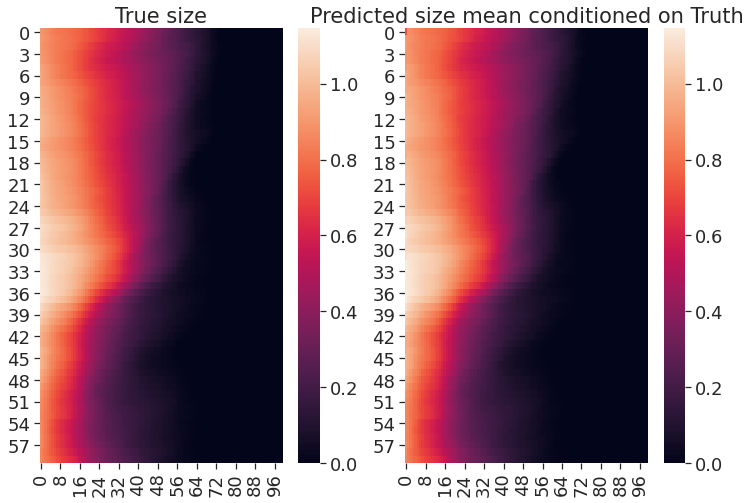

In [38]:
fig, axs = plt.subplots(1, 2)
image = size_np[i]
vmin = np.min(image)
vmax = np.max(image)
sb.heatmap(image, ax=axs[0], vmin=vmin, vmax=vmax)
axs[0].set_title('True size')
sb.heatmap(pred[0][0, 0, :, :].cpu().detach().numpy() / 1e4, ax=axs[1], vmin=vmin, vmax=vmax)
axs[1].set_title('Predicted size mean conditioned on Truth')
plt.show()

### stdev

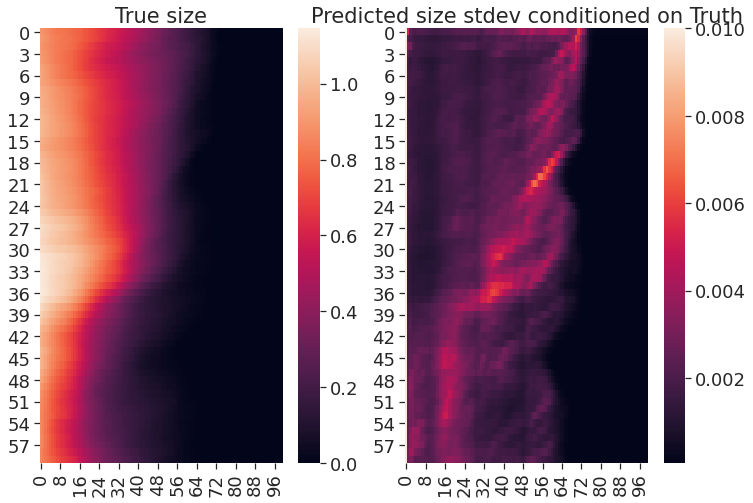

In [39]:
fig, axs = plt.subplots(1, 2)
image = size_np[i]
vmin = np.min(image)
vmax = np.max(image)
sb.heatmap(image, ax=axs[0], vmin=vmin, vmax=vmax)
axs[0].set_title('True size')
sb.heatmap(np.exp(pred[0][0, 1, :, :].cpu().detach().numpy() / 1e5) * 0.1, ax=axs[1], vmax=.01)
axs[1].set_title('Predicted size stdev conditioned on Truth')
plt.show()

## rad

### mean

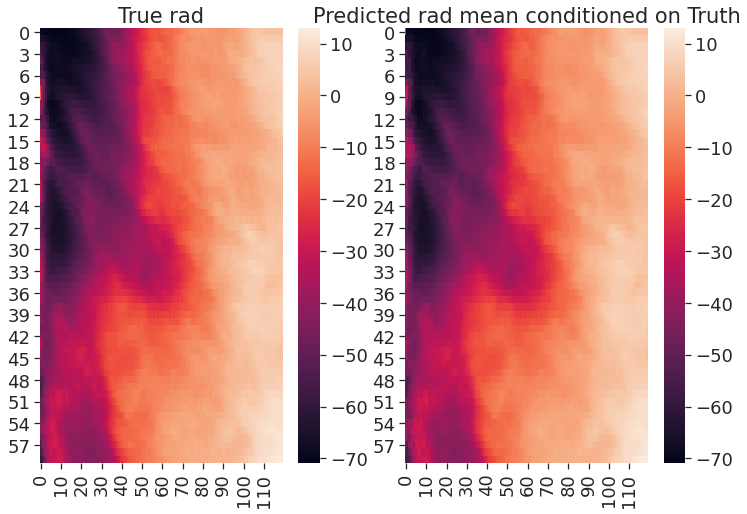

In [40]:
fig, axs = plt.subplots(1, 2)
image = rad_np[i]
vmin = np.min(image)
vmax = np.max(image)
sb.heatmap(image, ax=axs[0], vmin=vmin, vmax=vmax)
axs[0].set_title('True rad')
sb.heatmap(pred[1][0, 0, :, :].cpu().detach().numpy() / 1e4, ax=axs[1], vmin=vmin, vmax=vmax)
axs[1].set_title('Predicted rad mean conditioned on Truth')
plt.show()

### stdev

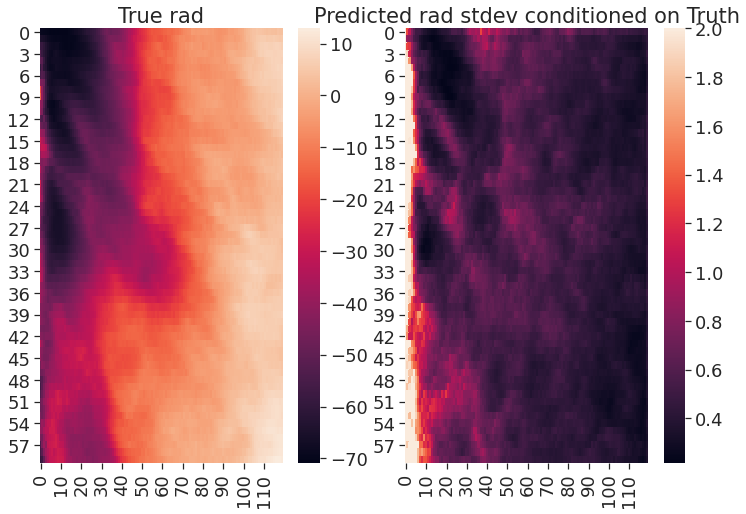

In [41]:
fig, axs = plt.subplots(1, 2)
image = rad_np[i]
vmin = np.min(image)
vmax = np.max(image)
sb.heatmap(image, ax=axs[0], vmin=vmin, vmax=vmax)
axs[0].set_title('True rad')
sb.heatmap(np.exp(pred[1][0, 1, :, :].cpu().detach().numpy() / 1e5) * 10, ax=axs[1], vmax=2)
axs[1].set_title('Predicted rad stdev conditioned on Truth')
plt.show()

# simulation

In [42]:
def sample(model, size_mtx, rad_mtx, extra_feats_size_mtx, extra_feats_rad_mtx, row_simulate_start):
    """Generates new samples from the model.

    Args:
        conditioned_on: A batch of partial samples to condition the generation on.
            Only dimensions with values < 0 are sampled while dimensions with
            values >= 0 are left unchanged. If 'None', an unconditional sample is
            generated.
    """
    
    with torch.no_grad():
        num_rows = size_mtx.shape[0]
        num_size_cols = size_mtx.shape[1]
        num_rad_cols = rad_mtx.shape[1]
        # double for loop through all pixels starting from simulation row
        for row in range(row_simulate_start, num_rows):
            for col in range(num_rad_cols):
                # interested in predicting pixel (row, col)
                out_size, out_rad = model.forward(
                    torch.Tensor([[size_mtx]]).to(device),
                    torch.Tensor([[rad_mtx]]).to(device),
                    torch.Tensor([extra_feats_size_mtx]).to(device),
                    torch.Tensor([extra_feats_rad_mtx]).to(device),
                )
                # compute mean/stdev of both orbs for pixel (row, col)
                if col < num_size_cols:
                    mean_size = out_size[0, 0, row, col] / 1e4
                    stdev_size = np.exp(torch.Tensor.cpu(out_size[0, 1, row, col]) / 1e5) * 0.1

                mean_rad = out_rad[0, 0, row, col] / 1e4
                stdev_rad = np.exp(torch.Tensor.cpu(out_rad[0, 1, row, col]) / 1e5) * 10

                # sample pixel value from each orb
                # set (row, col) pixel value in orb to this sampled one
                if col < num_size_cols:
                    size_val = np.random.normal(torch.Tensor.cpu(mean_size), torch.Tensor.cpu(stdev_size))
                    size_mtx[row, col] = size_val
                
                rad_val = np.random.normal(torch.Tensor.cpu(mean_rad), torch.Tensor.cpu(stdev_rad))
                rad_mtx[row, col] = rad_val
            # take PCA after row is fully simulated and set feature values
            if row + 1 < num_rows:
                rad_pcas = pca_rad.transform((rad_mtx[row, :] - np.array(rad_cols_means)).reshape(1, -1))[0]
                rad_pca1_val, rad_pca2_val = rad_pcas[0], rad_pcas[1]
                # set PCA coeffs for next row
                extra_feats_size_mtx[2, row + 1, :] = rad_pca1_val
                extra_feats_size_mtx[3, row + 1, :] = rad_pca2_val
                
                size_pcas = pca_size.transform((size_mtx[row, :] - np.array(size_cols_means)).reshape(1, -1))[0]
                size_pca1_val, size_pca2_val, size_pca3_val = size_pcas[0], size_pcas[1], size_pcas[2]
                extra_feats_rad_mtx[2, row + 1, :] = size_pca1_val
                extra_feats_rad_mtx[3, row + 1, :] = size_pca2_val
                extra_feats_rad_mtx[4, row + 1, :] = size_pca3_val
        return size_mtx, rad_mtx, extra_feats_size_mtx, extra_feats_rad_mtx, row_simulate_start

In [43]:
i = 5000
size_np_point = size_np[i].copy()
rad_np_point = rad_np[i].copy()
extra_feats_size_np_point = extra_feats_size_np[i].copy()
extra_feats_rad_np_point = extra_feats_rad_np[i].copy()

simulation = sample(model, size_np_point, rad_np_point, extra_feats_size_np_point, extra_feats_rad_np_point, 48)

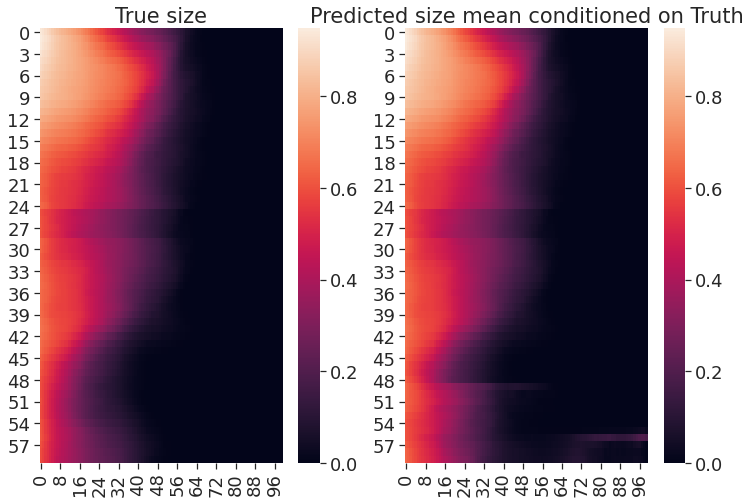

In [44]:
fig, axs = plt.subplots(1, 2)
image = size_np[i]
vmin = np.min(image)
vmax = np.max(image)
sb.heatmap(image, ax=axs[0], vmin=vmin, vmax=vmax)
axs[0].set_title('True size')
sb.heatmap(simulation[0], ax=axs[1], vmin=vmin, vmax=vmax)
axs[1].set_title('Predicted size mean conditioned on Truth')
plt.show()

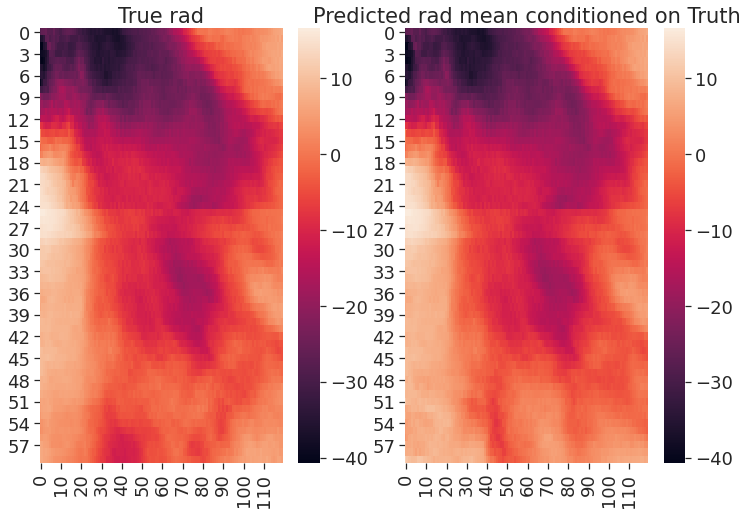

In [45]:
fig, axs = plt.subplots(1, 2)
image = rad_np[i]
vmin = np.min(image)
vmax = np.max(image)
sb.heatmap(image, ax=axs[0], vmin=vmin, vmax=vmax)
axs[0].set_title('True rad')
sb.heatmap(simulation[1], ax=axs[1], vmin=vmin, vmax=vmax)
axs[1].set_title('Predicted rad mean conditioned on Truth')
plt.show()

# multiple simulations

In [46]:
rad_sims = {}
size_sims = {}

In [47]:
def plot_multiple_simulations(model, idx, ID, timestamps, rad=True):
    # global variables for caching simulations
    global rad_sims
    global size_sims
    if (not rad_sims.get(idx)) or (not size_sims.get(idx)):
        rad_sims[idx] = []
        size_sims[idx] = []
        for _ in range(5):
            size_np_point = size_np[idx].copy()
            rad_np_point = rad_np[idx].copy()
            extra_feats_size_np_point = extra_feats_size_np[idx].copy()
            extra_feats_rad_np_point = extra_feats_rad_np[idx].copy()
            
            simulation = sample(model, size_np_point, rad_np_point, extra_feats_size_np_point, extra_feats_rad_np_point, 48)
            
            size_sims[idx].append(simulation[0])
            rad_sims[idx].append(simulation[1])

    if rad:
        x = rad_sims
        image = rad_np[idx]
    else:
        x = size_sims
        image = size_np[idx]
    fig, axs = plt.subplots(2,3)
    # random index generated for real orb
    rand_idx = np.random.randint(0, 6)
    ii = 0
    vmin = np.min(image)
    vmax = np.max(image)
    # plots in matplotlib subplots with corresponding labels
    for jj in range(6):
        if jj == rand_idx:
            sb.heatmap(image, ax=axs[jj // 3, jj % 3], vmin=vmin, vmax=vmax)
            axs[jj // 3, jj % 3].set_title('Real', size=16)
        else:
            sb.heatmap(x[idx][ii], ax=axs[jj // 3, jj % 3], vmin=vmin, vmax=vmax, cbar_kws={'label': 'Average Temperature [C]' if rad else 'Normalized Size'})

            axs[jj // 3, jj % 3].set_title('Simulated', size=16)
            ii += 1
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=10)
        if rad:
            cax.set_ylabel('Average Temperature [C]', size=14)
        else:
            cax.set_ylabel('Normalized Size', size=14)
        
        axs[jj // 3, jj % 3].axhline(48)
        if rad:
            axs[jj // 3, jj % 3].set_xlabel('Radius [km]', size=14)
        else:
            axs[jj // 3, jj % 3].set_xlabel('Temperature [C]', size=14)
        
        xticks = axs[jj // 3, jj % 3].get_xticklabels()
        if rad:
            new_ticklabels = [int(5 * float(tick.get_text())) for tick in xticks]
        else:
            new_ticklabels = [int(-1 - float(tick.get_text())) for tick in xticks]
        axs[jj // 3, jj % 3].set_xticklabels(new_ticklabels, rotation=50, size=12)
        
        yticks = axs[jj // 3, jj % 3].get_yticklabels()
        axs[jj // 3, jj % 3].set_yticklabels([timestamps[int(tick.get_text())] for tick in yticks], rotation=45, size=10)
    plt.suptitle(f'Real and Simulated {"Radial Profiles" if rad else "Sizes"} for {ID}', size=20)
    fig.subplots_adjust(top=0.88)
    plt.tight_layout()
    plt.show()
    for _ in range(30):
        print('')
    print(rand_idx)

In [48]:
def find_rad_storm_id_timestamp(index):
    for storm_id in storm_ids:
        for i in range(df_rad.loc[df_rad['ID'] == storm_id, :].shape[0]):
            s = df_rad.loc[df_rad['ID'] == storm_id, rad_cols].values[i:(i+60)]
            if s.shape[0] == 60 and (rad_np[index] == s).all():
                timestamp_vec = df_rad.loc[df_rad['ID'] == storm_id, 'timestamp'][i:(i+60)]
                return timestamp_vec, storm_id

In [49]:
idx = 6100

In [50]:
timestamp_vec, storm_id_sim = find_rad_storm_id_timestamp(idx)

In [ ]:
plot_multiple_simulations(model, idx, storm_id_sim, timestamp_vec.dt.strftime('%Y-%m-%d %H:%M').values, rad=False)

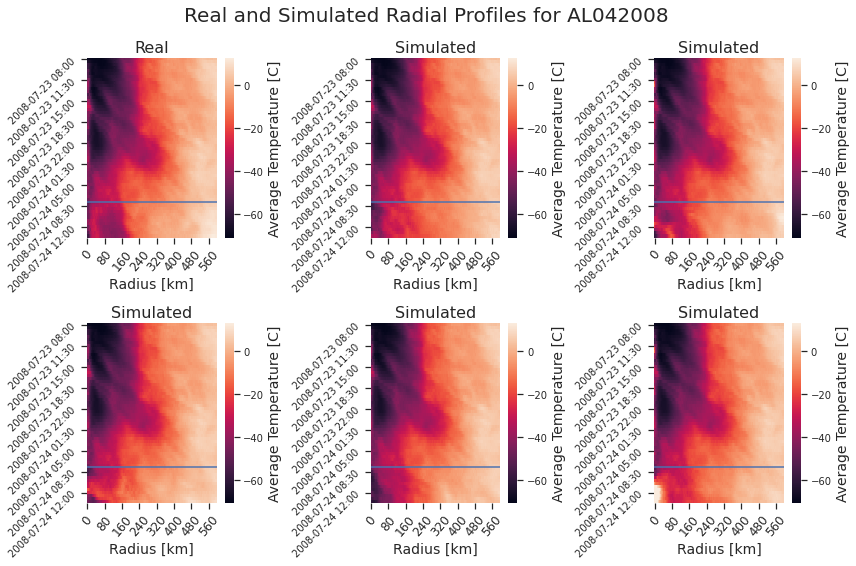































0


In [51]:
plot_multiple_simulations(model, idx, storm_id_sim, timestamp_vec.dt.strftime('%Y-%m-%d %H:%M').values, rad=True)

# storm plot

In [ ]:
# 43, 44, 48, 50, 56

In [ ]:
np.array(storm_ids)[[6, 15, 17, 22, 23, 24, 26]]

In [ ]:
storm_id = storm_ids[26]
storm_df = df_size_rad_tc.loc[df_size_rad_tc['ID'] == storm_id, :].sort_values('timestamp')

fig, axs = plt.subplots(1, 2)
sb.heatmap(storm_df[size_cols].values, ax=axs[0])
axs[0].set_title('size')
sb.heatmap(storm_df[rad_cols].values, ax=axs[1])
axs[1].set_title('rad')
plt.show()